<a href="https://colab.research.google.com/github/zekaouinoureddine/Advanced-transformer-based-models-on-opinion-mining/blob/master/notebooks/Movie_Reviews_ELECTRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers -q

     |████████████████████████████████| 4.2 MB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 57.3 MB/s 
     |████████████████████████████████| 84 kB 4.0 MB/s 
     |████████████████████████████████| 596 kB 81.2 MB/s 


### Required libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn import model_selection, metrics

from tqdm import tqdm
from collections import defaultdict

In [ ]:
!gdown --id 1xJYm-tNMllxx82_CQ1K1R5q0JW9KUV1j -q
!unzip IMDb.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Archive:  IMDb.zip
  inflating: IMDB Dataset.csv        


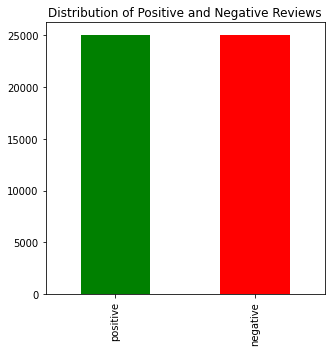

In [ ]:
df = pd.read_csv("IMDB Dataset.csv")

df["sentiment"].value_counts().plot(kind='bar',
                                    color=['green','red'],
                                    title='Distribution of Positive and Negative Reviews',
                                    figsize=(5,5));

In [ ]:
class Config:
  MAX_LEN = 384
  TRAIN_BATCH_SIZE = 8
  VALID_BATCH_SIZE = 4
  EPOCHS = 4
  DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  ELECTRA_PATH = "google/electra-base-discriminator"
  MODEL_PATH = "ELECTRAModel.bin"
  TRAINING_DATA = "IMDB Dataset.csv"

  TOKENIZER = transformers.ElectraTokenizer.from_pretrained(ELECTRA_PATH, do_lower_case = True)
  MODEL = transformers.ElectraModel.from_pretrained(ELECTRA_PATH, return_dict=False)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/666 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Dataset

In [ ]:
class DataProcess:
  def __init__(self, review):
    self.tokenizer = Config.TOKENIZER
    self.max_len = Config.MAX_LEN
    self.review = review
    
  def preprocess_bert(self):
    reviw = " ".join(self.review.split())
    inputs = self.tokenizer.encode_plus(
        reviw,
        None,
        add_special_tokens=True,
        max_length=self.max_len,
        # padding = "max_length",
        truncation=True
        )

    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    token_type_ids = inputs["token_type_ids"]

    return (
        torch.tensor(input_ids, dtype=torch.long).unsqueeze(0),
        torch.tensor(attention_mask, dtype=torch.long).unsqueeze(0),
        torch.tensor(token_type_ids, dtype=torch.long).unsqueeze(0)
        )
    
  def preprocess_output(self, outputs):
    outputs = torch.sigmoid(outputs).cpu().detach().numpy()
    return outputs[0][0]


class MovieReviewDatSet:
  def __init__(self, data_path):
    
    self.data = pd.read_csv(data_path).fillna('none')
    self.data.sentiment = self.data.sentiment.apply(lambda x: 1 if x == "positive" else 0)
    self.data = self.data.reset_index(drop=True)
    self.tokenizer = Config.TOKENIZER
    self.max_len = Config.MAX_LEN
    self.review = self.data.review.values
    self.label = self.data.sentiment.values

  def __len__(self):
    return len(self.review)

  def __getitem__(self, item):
    review = str(self.review[item])
    review = " ".join(review.split())

    inputs = self.tokenizer.encode_plus(
        review,
        None,
        add_special_tokens = True,
        max_length = self.max_len,
        padding = "max_length",
        truncation= True
    )

    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    token_type_ids = inputs["token_type_ids"]

    return {
        "input_ids" : torch.tensor(input_ids, dtype=torch.long),
        "attention_mask" : torch.tensor(attention_mask, dtype=torch.long),
        "token_type_ids" : torch.tensor(token_type_ids, dtype=torch.long),
        "labels" : torch.tensor(self.label[item], dtype=torch.float)
        }

### Model

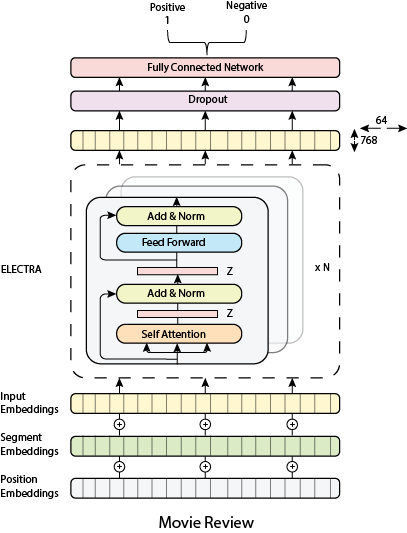

In [ ]:
class ELECTRAModel(nn.Module):
  def __init__(self):
    super(ELECTRAModel, self).__init__()
    self.electra = Config.MODEL
    self.electra_drop = nn.Dropout(0.3)
    self.out = nn.Linear(768, 1)

  def forward(self, input_ids, attention_mask, token_type_ids):
    discriminator_hidden_states  = self.electra(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    mean_last_hidden_state = torch.mean(discriminator_hidden_states[0],1)
    rbo = self.electra_drop(mean_last_hidden_state)
    output = self.out(rbo)
    
    return output

### Engine

In [ ]:
def loss_fn(outputs, labels):
  return nn.BCEWithLogitsLoss()(outputs, labels.view(-1, 1))

def train_fn(train_dataloader, model, optimizer, device, scheduler):
  model.train()
  final_loss = 0

  fin_labels = []
  fin_outputs = []
  for bi, d in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    input_ids = d["input_ids"]
    attention_mask = d["attention_mask"]
    token_type_ids = d["token_type_ids"]
    labels = d["labels"]

    input_ids = input_ids.to(device, dtype=torch.long)
    attention_mask = attention_mask.to(device, dtype=torch.long)
    token_type_ids = token_type_ids.to(device, dtype = torch.long)
    labels = labels.to(device, dtype = torch.float)

    optimizer.zero_grad()
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids = token_type_ids)
    loss = loss_fn(outputs, labels)
    
    final_loss += loss.item()
    fin_labels.extend(labels.cpu().detach().numpy().tolist())
    fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    
    loss.backward()
    optimizer.step()
    scheduler.step()

  return fin_outputs, fin_labels, final_loss/len(train_dataloader)

def eval_fn(valid_dataloader, model, device):
  model.eval()
  final_loss = 0

  fin_labels = []
  fin_outputs = []
  with torch.no_grad():
    for bi, d in tqdm(enumerate(valid_dataloader), total=len(valid_dataloader)):
      input_ids = d["input_ids"]
      attention_mask = d["attention_mask"]
      token_type_ids = d["token_type_ids"]
      labels = d["labels"]

      input_ids = input_ids.to(device, dtype=torch.long)
      attention_mask = attention_mask.to(device, dtype=torch.long)
      token_type_ids = token_type_ids.to(device, dtype = torch.long)
      labels = labels.to(device, dtype = torch.float)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids = token_type_ids)
      
      loss = loss_fn(outputs, labels)
      final_loss += loss.item()
      
      fin_labels.extend(labels.cpu().detach().numpy().tolist())
      fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
      

  return fin_outputs, fin_labels, final_loss/len(valid_dataloader)

### Train

In [ ]:
dataset = MovieReviewDatSet(Config.TRAINING_DATA)

train_data, valid_data = model_selection.train_test_split(dataset, test_size = 0.1)
train_dataloader = DataLoader(train_data, batch_size=Config.TRAIN_BATCH_SIZE, num_workers=4)
valid_dataloader = DataLoader(valid_data, batch_size=Config.VALID_BATCH_SIZE, num_workers=1)

model = ELECTRAModel()
model.to(Config.DEVICE)

param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
                        {
                            "params": [
                                       p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                                       ],
                         "weight_decay": 0.001,
                         },
                        {
                            "params": [
                                       p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                                       ],
                         "weight_decay": 0.0,
                         },
                        ]

num_train_steps = int(len(train_data) / Config.TRAIN_BATCH_SIZE * Config.EPOCHS)
optimizer = AdamW(optimizer_parameters, lr=3e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
    )

history = defaultdict(list)

best_accuracy = 0
for epoch in range(1, Config.EPOCHS+1):
  train_outputs, train_labels, train_loss = train_fn(train_dataloader, model, optimizer, Config.DEVICE, scheduler)
  valid_outputs, valid_labels, valid_loss = eval_fn(valid_dataloader, model, Config.DEVICE)
  
  train_outputs = np.array(train_outputs) >= 0.5
  valid_outputs = np.array(valid_outputs) >= 0.5

  train_accuracy = metrics.accuracy_score(train_labels, train_outputs)
  valid_accuracy = metrics.accuracy_score(valid_labels, valid_outputs)

  print(f"Epoch: {epoch}\nTrain Loss: {train_loss} - Train Accuracy: {train_accuracy} \nValid Loss: {valid_loss} - Valid Accuracy: {valid_accuracy}\n")
  
  history['Train Loss'].append(train_loss)
  history['Train Accuracy'].append(train_accuracy)
  history['Valid Loss'].append(valid_loss)
  history['Valid Accuracy'].append(valid_accuracy)
  
  if valid_accuracy > best_accuracy:
    torch.save(model.state_dict(), Config.MODEL_PATH)
    best_accuracy = valid_accuracy

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
100%|██████████| 1250/1250 [00:19<00:00, 65.75it/s]


Epoch: 1
Train Loss: 0.17864503918050065 - Train Accuracy: 0.9325333333333333 
Valid Loss: 0.14559101655194537 - Valid Accuracy: 0.9498



100%|██████████| 1250/1250 [00:18<00:00, 66.00it/s]


Epoch: 2
Train Loss: 0.08837034320597434 - Train Accuracy: 0.9705555555555555 
Valid Loss: 0.165488288845215 - Valid Accuracy: 0.9504



100%|██████████| 1250/1250 [00:18<00:00, 65.85it/s]


Epoch: 3
Train Loss: 0.040830054026552376 - Train Accuracy: 0.9885555555555555 
Valid Loss: 0.17896205378533342 - Valid Accuracy: 0.9536



100%|██████████| 1250/1250 [00:19<00:00, 65.59it/s]


Epoch: 4
Train Loss: 0.020947803694568574 - Train Accuracy: 0.9949777777777777 
Valid Loss: 0.19423187617284712 - Valid Accuracy: 0.9558



### Error Analysis & Performance auditing

In [ ]:
def get_metrics(labels, outputs):
  accuracy = metrics.accuracy_score(labels, outputs)
  recall = metrics.recall_score(labels, outputs)
  precision = metrics.precision_score(labels, outputs)
  f1 = metrics.f1_score(labels, outputs)
  return accuracy, recall, precision, f1


Results summary

Accuracy Score  : 0.9558
Recall Score    : 0.9577689243027888
Precision Score : 0.9543469630805875
F1 Score        : 0.95605488168622

Classification report 

               precision    recall  f1-score   support

         0.0       0.96      0.95      0.96      2490
         1.0       0.95      0.96      0.96      2510

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



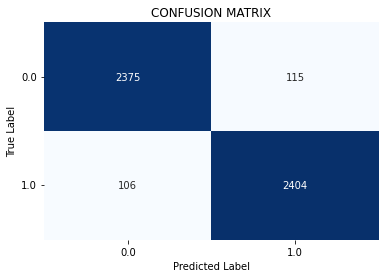

In [ ]:
accuracy, recall, precision, f1 = get_metrics(valid_labels, valid_outputs)

print("==="*50)
print("\nResults summary\n")
print(f"Accuracy Score  : {accuracy}")
print(f"Recall Score    : {recall}")
print(f"Precision Score : {precision}")
print(f"F1 Score        : {f1}")

print("==="*50)
print("\nClassification report \n\n", metrics.classification_report(valid_labels, valid_outputs))

print("==="*50)
cm = metrics.confusion_matrix(valid_labels, valid_outputs)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Predicted Label", 
       ylabel="True Label", 
       xticklabels=np.unique(valid_labels), 
       yticklabels=np.unique(valid_labels), 
       title="CONFUSION MATRIX")
plt.yticks(rotation=0);

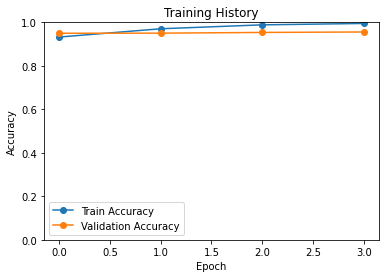

In [ ]:
plt.plot(history['Train Accuracy'], '-o', label='Train Accuracy')
plt.plot(history['Valid Accuracy'], '-o', label='Validation Accuracy')
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

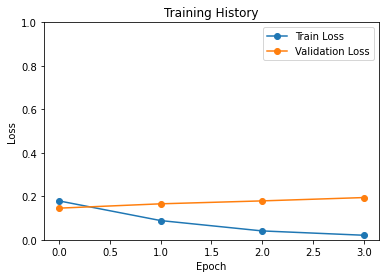

In [ ]:
plt.plot(history['Train Loss'], '-o', label='Train Loss')
plt.plot(history['Valid Loss'], '-o', label='Validation Loss')
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Inference

In [ ]:
model = ELECTRAModel()
model.to(Config.DEVICE)
model.load_state_dict(
    torch.load(
        Config.MODEL_PATH,
        map_location=torch.device(Config.DEVICE)
        )
    )

def predict(review: str):
  data = DataProcess(review)
  input_ids, attention_mask, token_type_ids = data.preprocess_bert()
  
  input_ids = input_ids.to(Config.DEVICE, dtype=torch.long)
  attention_mask = attention_mask.to(Config.DEVICE, dtype=torch.long)
  token_type_ids = token_type_ids.to(Config.DEVICE, dtype=torch.long)
  
  outputs = model(input_ids, attention_mask, token_type_ids) 
  positive_prediction = data.preprocess_output(outputs)
  negative_prediction = 1 - positive_prediction
  
  return {
      "review": review,
      "positive": str(positive_prediction),
      "negative": str(negative_prediction),
  }

In [ ]:
sentiment = predict("I like this amazing movie")
print(sentiment)

{'review': 'I like this amazing movie', 'positive': '0.9977416', 'negative': '0.0022584199905395508'}


References:
* **Kevin Clark, Minh-Thang Luong, Quoc V. Le, Christopher D. Manning. 2020. [ELECTRA: Pre-training Text Encoders as Discriminators Rather Than Generators](https://arxiv.org/abs/2003.10555)**